In [1]:
from dotenv import load_dotenv
load_dotenv()

import boto3
import os
import json

region = os.getenv('AWS_DEFAULT_REGION')
bedrock_runtime = boto3.client(
    'bedrock-runtime',
    region_name=region
)

In [2]:
import logging
import boto3
import time
import json
import uuid
import pprint
import os
from opensearchpy import OpenSearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth

In [3]:
incontext_prompt = """**Préprompt pour le Chatbot Financier**

**1. Description de la firme :**
Vous fournirez un aperçu complet de la firme, y compris son secteur d'activité, ses services et sa position sur le marché.

**2. Contexte de la tâche :**
Vous agirez en tant qu'assistant financier qui aide les utilisateurs à rassembler des informations détaillées sur une entreprise spécifique.

**3. Contexte ton :**
Maintenez un ton professionnel et informatif tout en étant accessible et clair dans vos réponses.

**4. Données et documents de fond :**
Faites référence aux rapports financiers, aux communiqués de presse et à tout autre document pertinent pour garantir des informations précises.

**5. Description détaillée de la tâche et règles :**
- Fournissez des informations structurées au format JSON.
- Incluez les sections suivantes :
  - **description_firme** : Description de la firme.
  - **equipe_direction** : Liste des membres de l'équipe de direction.
    - **nom** : Nom du membre.
    - **poste** : Poste occupé par le membre.
  - **principaux_actionnaires** : Liste des principaux actionnaires.
    - **nom** : Nom de l'actionnaire.
    - **part** : Part détenue par l'actionnaire.
  - **informations_pertinentes** : Informations supplémentaires pertinentes.
  - **nouvelles_recentes** : Liste des nouvelles récentes.
    - **date** : Date de la nouvelle.
    - **titre** : Titre de la nouvelle.
  - **risques_et_facteurs_de_croissance** : Analyse des risques et des facteurs de croissance.
    - **risques** : Liste des risques identifiés.
    - **facteurs_de_croissance** : Liste des facteurs de croissance.
  - **analyse_reseaux_sociaux** : Analyse des réseaux sociaux (analystes financiers).
    - **analystes** : Liste des analystes financiers.
      - **nom** : Nom de l'analyste.
      - **sentiment** : Sentiment de l'analyste (positif, négatif, neutre).
      - **commentaire** : Commentaire de l'analyste.
- Si certaines informations ne sont pas disponibles, indiquez-le clairement dans la sortie JSON.

**6. Exemples :**
Exemple de sortie JSON :
```json
{
  "description_firme": "La société XYZ est un fournisseur leader de solutions technologiques, spécialisée dans les services cloud et la cybersécurité.",
  "equipe_direction": [
    {
      "nom": "John Doe",
      "poste": "PDG"
    },
    {
      "nom": "Jane Smith",
      "poste": "Directrice financière"
    },
    {
      "nom": "Albert Dupont",
      "poste": "Directeur technique"
    }
  ],
  "principaux_actionnaires": [
    {
      "nom": "Investisseur A",
      "part": "15%"
    },
    {
      "nom": "Investisseur B",
      "part": "10%"
    }
  ],
  "informations_pertinentes": "La société XYZ a récemment élargi ses opérations en Europe et a lancé plusieurs nouveaux produits innovants.",
  "nouvelles_recentes": [
    {
      "date": "2024-11-01",
      "titre": "La société XYZ annonce un nouveau partenariat avec ABC Corp."
    },
    {
      "date": "2024-10-15",
      "titre": "XYZ remporte le prix de la meilleure innovation technologique."
    }
  ],
  "risques_et_facteurs_de_croissance": {
    "risques": [
      "Volatilité du marché",
      "Changements réglementaires",
      "Concurrence accrue"
    ],
    "facteurs_de_croissance": [
      "Expansion sur de nouveaux marchés",
      "Avancées technologiques",
      "Partenariats stratégiques"
    ]
  },
  "analyse_reseaux_sociaux": {
    "analystes": [
      {
        "nom": "Analyste A",
        "sentiment": "positif",
        "commentaire": "Potentiel de croissance solide, surtout dans le secteur du cloud."
      },
      {
        "nom": "Analyste B",
        "sentiment": "neutre",
        "commentaire": "Des défis subsistent en matière de réglementation."
      }
    ]
  }
}
"""

In [4]:
# setting logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
# getting boto3 clients for required AWS services
sts_client = boto3.client('sts')
iam_client = boto3.client('iam')
s3_client = boto3.client('s3')
lambda_client = boto3.client('lambda')
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime')
open_search_serverless_client = boto3.client('opensearchserverless')

In [6]:
session = boto3.session.Session()
region = session.region_name
account_id = sts_client.get_caller_identity()["Account"]
region, account_id

('us-west-2', '939490215743')

In [7]:
suffix = int(time.time())
print(suffix)

1730670621


In [8]:
# Generate random prefix for unique IAM roles, agent name and S3 Bucket and 
# assign variables
suffix = f"{region}-{account_id}"

suffix = int(time.time())
agent_name = f"bedrock-docs-kb-agents{suffix}"

agent_alias_name = f"bedrock-docs-alias{suffix}"




#bucket_name = f'{agent_name}-{suffix}'

bucket_name = f'my-data-bucket-2024'
bucket_arn = f"arn:aws:s3:::{bucket_name}"



#bedrock_agent_bedrock_allow_policy_name = f"bda-bedrock-allow-{suffix}"

#bedrock_agent_s3_allow_policy_name = f"bda-s3-allow-{suffix}"

#bedrock_agent_kb_allow_policy_name = f"bda-kb-allow-{suffix}"



import time

suffix = int(time.time())  # Utilise l'horodatage actuel comme suffixe

bedrock_agent_bedrock_allow_policy_name = f"bda-bedrock-allow-{suffix}"
bedrock_agent_s3_allow_policy_name = f"bda-s3-allow-{suffix}"
bedrock_agent_kb_allow_policy_name = f"bda-kb-allow-{suffix}"



agent_role_name = f'AmazonBedrockExecutionRoleForAgents_bedrock_docs{suffix}'

#kb_name = f'bedrock-docs-kb-{suffix}'
# Cela crée un nombre unique basé sur l'heure actuelle

kb_name = f'bedrock-docs-kb-{suffix}'

data_source_name = f'bedrock-docs-kb-docs-{suffix}'
kb_files_path = 'kb_documents'
kb_key = 'kb_documents'

kb_role_name = f'rapport1_test_docs{suffix}'



kb_bedrock_allow_policy_name = f"bd-kb-bedrock-allow-{suffix}"

kb_aoss_allow_policy_name = f"bd-kb-aoss-allow-{suffix}"

kb_s3_allow_policy_name = f"bd-kb-s3-allow-{suffix}"

kb_collection_name = f'bd-kbc-{suffix}'

# Select Amazon titan as the embedding model
embedding_model_arn = f'arn:aws:bedrock:{region}::foundation-model/amazon.titan-embed-text-v1'
kb_vector_index_name = "bedrock-knowledge-base-index"
kb_metadataField = 'bedrock-knowledge-base-metadata'
kb_textField = 'bedrock-knowledge-base-text'
kb_vectorField = 'bedrock-knowledge-base-vector'
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

# agent configuration
agent_instruction =incontext_prompt
#"""
#Analyze the provided financial report to generate a concise summary that includes key information such as revenue, expenses, profit margins, and significant changes compared to previous periods. Additionally, evaluate the sentiment in the report, focusing on the letters to shareholders and management commentary. Determine whether the sentiment is optimistic, pessimistic, or neutral, and present your findings in a structured format. Include relevant quotes or phrases to support your sentiment analysis and provide visualizations if applicable. la reponse final doit etre dans un format json , avec 3 cles 
#"""

In [9]:
print(bucket_name)

my-data-bucket-2024


In [10]:
if region != 'us-east-1':
    s3_client.create_bucket(
        Bucket=bucket_name.lower(),
        CreateBucketConfiguration={'LocationConstraint': region}
    )
else:
    s3_client.create_bucket(Bucket=bucket_name)

BucketAlreadyOwnedByYou: An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.

In [11]:
import os
import boto3

#kb_documents/Rapport_Act_2018_Fr.pdf
#kb_documents
# Upload PDF files to S3
kb_files_path = 'financedata'
for f in os.listdir(kb_files_path):
    if f.endswith(".pdf"):
        local_file_path = os.path.join(kb_files_path, f)
        s3_client.upload_file(local_file_path, bucket_name, os.path.join(kb_key, f))
        print(f"Uploaded {f} to s3://{bucket_name}/{kb_key}/{f}")


Uploaded 9465D_Rapport_Annuel_2023_CCA_FR_F.pdf to s3://my-data-bucket-2024/kb_documents/9465D_Rapport_Annuel_2023_CCA_FR_F.pdf
Uploaded 2023-rapport-financier-annuel-bce.pdf to s3://my-data-bucket-2024/kb_documents/2023-rapport-financier-annuel-bce.pdf
Uploaded Hydro One Limited Annual Report 2022.pdf to s3://my-data-bucket-2024/kb_documents/Hydro One Limited Annual Report 2022.pdf
Uploaded Hydro One Limited Annual Report 2023.pdf to s3://my-data-bucket-2024/kb_documents/Hydro One Limited Annual Report 2023.pdf
Uploaded 2020-rapport-annuel-bce.pdf to s3://my-data-bucket-2024/kb_documents/2020-rapport-annuel-bce.pdf
Uploaded Rogers-2023-Annual-Report.pdf to s3://my-data-bucket-2024/kb_documents/Rogers-2023-Annual-Report.pdf
Uploaded 2022-annuel-10Q-FR-09122022-Final.pdf to s3://my-data-bucket-2024/kb_documents/2022-annuel-10Q-FR-09122022-Final.pdf
Uploaded Rogers-2022-Annual-Report-1.pdf to s3://my-data-bucket-2024/kb_documents/Rogers-2022-Annual-Report-1.pdf
Uploaded 2022-rapport-fina

In [14]:
# Upload Knowledge Base files to thikb_files_paths s3 bucket

#for f in os.listdir(kb_files_path):
    #if f.endswith(".pdf"):
        #s3_client.upload_file(kb_files_path+'/'+f, bucket_name, kb_key+'/'+f)

In [12]:
import boto3

iam_client = boto3.client('iam')
policies = iam_client.list_policies(Scope='Local')  # List only your policies

for policy in policies['Policies']:
    print(policy['PolicyName'])


bd-kb-s3-allow-1730624761
bd-kb-bedrock-allow-1730646173
bd-kb-bedrock-allow-1730624479
bda-bedrock-allow-1730646923
bd-kb-bedrock-allow-1730609702
bda-bedrock-allow-1730624479
iam_policy-0
bda-bedrock-allow-1730609928
bda-bedrock-allow-1730624761
bda-kb-allow-1730624761
bda-kb-allow-1730624479
bda-bedrock-allow-1730612149
AmazonSageMaker-ExecutionPolicy-20241102T134231
bd-kb-bedrock-allow-1730615197
bd-kb-s3-allow-1730615197
AmazonSageMakerServiceCatalogProductsUseRole-20241102T134284
bd-kb-bedrock-allow-1730664838
bd-kb-bedrock-allow-1730612149
bd-kb-aoss-allow-1730623728
bda-bedrock-allow-us-west-2-939490215743
bda-kb-allow-1730610699
AmazonBedrockFoundationModelPolicyForKnowledgeBase_9394
bd-kb-bedrock-allow-us-west-2-939490215743
bd-kb-aoss-allow-1730613481
bd-kb-aoss-allow-1730609702
bd-kb-s3-allow-1730664838
bd-kb-bedrock-allow-1730614065
bd-kb-s3-allow-1730609702
ws-default-policy
Datathon2024
bd-kb-aoss-allow-1730614065
bd-kb-bedrock-allow-1730623728
bda-bedrock-allow-17306461

In [13]:
# Create IAM policies for KB to invoke embedding model
bedrock_kb_allow_fm_model_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "AmazonBedrockAgentBedrockFoundationModelPolicy",
            "Effect": "Allow",
            "Action": "bedrock:InvokeModel",
            "Resource": [
                embedding_model_arn
            ]
        }
    ]
}

kb_bedrock_policy_json = json.dumps(bedrock_kb_allow_fm_model_policy_statement)

kb_bedrock_policy = iam_client.create_policy(
    PolicyName=kb_bedrock_allow_policy_name,
    PolicyDocument=kb_bedrock_policy_json
)

In [14]:
# Create IAM policies for KB to access OpenSearch Serverless
bedrock_kb_allow_aoss_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "aoss:APIAccessAll",
            "Resource": [
                f"arn:aws:aoss:{region}:{account_id}:collection/*"
            ]
        }
    ]
}


kb_aoss_policy_json = json.dumps(bedrock_kb_allow_aoss_policy_statement)

kb_aoss_policy = iam_client.create_policy(
    PolicyName=kb_aoss_allow_policy_name,
    PolicyDocument=kb_aoss_policy_json
)

In [15]:
kb_s3_allow_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "AllowKBAccessDocuments",
            "Effect": "Allow",
            "Action": [
                "s3:GetObject",
                "s3:ListBucket"
            ],
            "Resource": [
                f"arn:aws:s3:::{bucket_name}/*",
                f"arn:aws:s3:::{bucket_name}"
            ],
            "Condition": {
                "StringEquals": {
                    "aws:ResourceAccount": f"{account_id}"
                }
            }
        }
    ]
}


kb_s3_json = json.dumps(kb_s3_allow_policy_statement)
kb_s3_policy = iam_client.create_policy(
    PolicyName=kb_s3_allow_policy_name,
    PolicyDocument=kb_s3_json
)

In [16]:
# Create IAM Role for the agent and attach IAM policies
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [{
          "Effect": "Allow",
          "Principal": {
            "Service": "bedrock.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
    }]
}



In [17]:
assume_role_policy_document_json = json.dumps(assume_role_policy_document)


In [18]:
kb_role = iam_client.create_role(
    RoleName=kb_role_name,
    AssumeRolePolicyDocument=assume_role_policy_document_json
)



In [19]:
# Pause to make sure role is created
time.sleep(10)
    
iam_client.attach_role_policy(
    RoleName=kb_role_name,
    PolicyArn=kb_bedrock_policy['Policy']['Arn']
)

iam_client.attach_role_policy(
    RoleName=kb_role_name,
    PolicyArn=kb_aoss_policy['Policy']['Arn']
)

iam_client.attach_role_policy(
    RoleName=kb_role_name,
    PolicyArn=kb_s3_policy['Policy']['Arn']
)

{'ResponseMetadata': {'RequestId': '9293641f-db9f-4be5-879f-2bd5b6f76212',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sun, 03 Nov 2024 21:51:31 GMT',
   'x-amzn-requestid': '9293641f-db9f-4be5-879f-2bd5b6f76212',
   'content-type': 'text/xml',
   'content-length': '212'},
  'RetryAttempts': 0}}

In [20]:
import boto3

iam_client = boto3.client('iam')

roles = iam_client.list_roles()
for role in roles['Roles']:
    print(role['RoleName'])


AmazonBedrockExecutionRoleForAgents_bedrock_docs1730623728
AmazonBedrockExecutionRoleForAgents_bedrock_docs1730624479
AmazonBedrockExecutionRoleForAgents_bedrock_docs1730624761
AmazonBedrockExecutionRoleForAgents_bedrock_docs1730646173
AmazonBedrockExecutionRoleForAgents_bedrock_docs1730646923
AmazonBedrockExecutionRoleForAgents_bedrock_docs1730664838
AmazonBedrockExecutionRoleForAgents_booking-agent
AmazonBedrockExecutionRoleForKnowledgeBase_9394
AmazonSageMakerServiceCatalogProductsLaunchRole
AmazonSageMakerServiceCatalogProductsUseRole
AWSServiceRoleForAmazonEMRServerless
AWSServiceRoleForAmazonOpenSearchServerless
AWSServiceRoleForAmazonOpenSearchService
AWSServiceRoleForAmazonSageMakerNotebooks
AWSServiceRoleForAWSCloud9
AWSServiceRoleForAWSLicenseManagerMemberAccountRole
AWSServiceRoleForAWSLicenseManagerRole
AWSServiceRoleForAWSServiceCatalogAppRegistry
AWSServiceRoleForCloudTrail
AWSServiceRoleForDevOpsGuru
AWSServiceRoleForElasticLoadBalancing
AWSServiceRoleForGlobalAccelerato

In [21]:
kb_role_arn = kb_role["Role"]["Arn"]
kb_role_arn

'arn:aws:iam::939490215743:role/rapport1_test_docs1730670623'

In [22]:
# Create OpenSearch Collection
security_policy_json = {
    "Rules": [
        {
            "ResourceType": "collection",
            "Resource":[
                f"collection/{kb_collection_name}"
            ]
        }
    ],
    "AWSOwnedKey": True
}
security_policy = open_search_serverless_client.create_security_policy(
    description='security policy of aoss collection',
    name=kb_collection_name,
    policy=json.dumps(security_policy_json),
    type='encryption'
)

In [23]:
network_policy_json = [
  {
    "Rules": [
      {
        "Resource": [
          f"collection/{kb_collection_name}"
        ],
        "ResourceType": "dashboard"
      },
      {
        "Resource": [
          f"collection/{kb_collection_name}"
        ],
        "ResourceType": "collection"
      }
    ],
    "AllowFromPublic": True
  }
]

network_policy = open_search_serverless_client.create_security_policy(
    description='network policy of aoss collection',
    name=kb_collection_name,
    policy=json.dumps(network_policy_json),
    type='network'
)

In [24]:
response = sts_client.get_caller_identity()
current_role = response['Arn']
current_role

'arn:aws:sts::939490215743:assumed-role/WSParticipantRole/Participant'

In [25]:
data_policy_json = [
  {
    "Rules": [
      {
        "Resource": [
          f"collection/{kb_collection_name}"
        ],
        "Permission": [
          "aoss:DescribeCollectionItems",
          "aoss:CreateCollectionItems",
          "aoss:UpdateCollectionItems",
          "aoss:DeleteCollectionItems"
        ],
        "ResourceType": "collection"
      },
      {
        "Resource": [
          f"index/{kb_collection_name}/*"
        ],
        "Permission": [
            "aoss:CreateIndex",
            "aoss:DeleteIndex",
            "aoss:UpdateIndex",
            "aoss:DescribeIndex",
            "aoss:ReadDocument",
            "aoss:WriteDocument"
        ],
        "ResourceType": "index"
      }
    ],
    "Principal": [
        kb_role_arn,
        f"arn:aws:sts::{account_id}:assumed-role/Admin/*",
        current_role
    ],
    "Description": ""
  }
]

data_policy = open_search_serverless_client.create_access_policy(
    description='data access policy for aoss collection',
    name=kb_collection_name,
    policy=json.dumps(data_policy_json),
    type='data'
)

In [26]:
opensearch_collection_response = open_search_serverless_client.create_collection(
    description='OpenSearch collection for Amazon Bedrock Knowledge Base',
    name=kb_collection_name,
    standbyReplicas='DISABLED',
    type='VECTORSEARCH'
)
opensearch_collection_response

{'createCollectionDetail': {'arn': 'arn:aws:aoss:us-west-2:939490215743:collection/tbn2knrfrmpxsconlpc1',
  'createdDate': 1730670716749,
  'description': 'OpenSearch collection for Amazon Bedrock Knowledge Base',
  'id': 'tbn2knrfrmpxsconlpc1',
  'kmsKeyArn': 'auto',
  'lastModifiedDate': 1730670716749,
  'name': 'bd-kbc-1730670623',
  'standbyReplicas': 'DISABLED',
  'status': 'CREATING',
  'type': 'VECTORSEARCH'},
 'ResponseMetadata': {'RequestId': 'f0f13e9f-a401-4f3d-8dde-676ca74e6bb7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f0f13e9f-a401-4f3d-8dde-676ca74e6bb7',
   'date': 'Sun, 03 Nov 2024 21:51:56 GMT',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '382',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [27]:
collection_arn = opensearch_collection_response["createCollectionDetail"]["arn"]
collection_arn

'arn:aws:aoss:us-west-2:939490215743:collection/tbn2knrfrmpxsconlpc1'

In [28]:
# wait for collection creation
response = open_search_serverless_client.batch_get_collection(names=[kb_collection_name])
# Periodically check collection status
while (response['collectionDetails'][0]['status']) == 'CREATING':
    print('Creating collection...')
    time.sleep(30)
    response = open_search_serverless_client.batch_get_collection(names=[kb_collection_name])
print('\nCollection successfully created:')
print(response["collectionDetails"])
# Extract the collection endpoint from the response
host = (response['collectionDetails'][0]['collectionEndpoint'])
final_host = host.replace("https://", "")
final_host

Creating collection...

Collection successfully created:
[{'arn': 'arn:aws:aoss:us-west-2:939490215743:collection/tbn2knrfrmpxsconlpc1', 'collectionEndpoint': 'https://tbn2knrfrmpxsconlpc1.us-west-2.aoss.amazonaws.com', 'createdDate': 1730670716749, 'dashboardEndpoint': 'https://tbn2knrfrmpxsconlpc1.us-west-2.aoss.amazonaws.com/_dashboards', 'description': 'OpenSearch collection for Amazon Bedrock Knowledge Base', 'id': 'tbn2knrfrmpxsconlpc1', 'kmsKeyArn': 'auto', 'lastModifiedDate': 1730670739720, 'name': 'bd-kbc-1730670623', 'standbyReplicas': 'DISABLED', 'status': 'ACTIVE', 'type': 'VECTORSEARCH'}]


'tbn2knrfrmpxsconlpc1.us-west-2.aoss.amazonaws.com'

In [29]:
credentials = boto3.Session().get_credentials()
service = 'aoss'
awsauth = AWS4Auth(
    credentials.access_key, 
    credentials.secret_key,
    region, 
    service, 
    session_token=credentials.token
)

# Build the OpenSearch client
open_search_client = OpenSearch(
    hosts=[{'host': final_host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)
# It can take up to a minute for data access rules to be enforced
time.sleep(45)
index_body = {
    "settings": {
        "index.knn": True,
        "number_of_shards": 1,
        "knn.algo_param.ef_search": 512,
        "number_of_replicas": 0,
    },
    "mappings": {
        "properties": {}
    }
}

index_body["mappings"]["properties"][kb_vectorField] = {
    "type": "knn_vector",
    "dimension": 1536,
    "method": {
         "name": "hnsw",
         "engine": "faiss"
    },
}

index_body["mappings"]["properties"][kb_textField] = {
    "type": "text"
}

index_body["mappings"]["properties"][kb_metadataField] = {
    "type": "text"
}

# Create index
response = open_search_client.indices.create(kb_vector_index_name, body=index_body)
print('\nCreating index:')
print(response)

[2024-11-03 16:52:34,506] p3894 {credentials.py:1147} INFO - Found credentials in environment variables.
[2024-11-03 16:53:20,286] p3894 {base.py:258} INFO - PUT https://tbn2knrfrmpxsconlpc1.us-west-2.aoss.amazonaws.com:443/bedrock-knowledge-base-index [status:200 request:0.773s]



Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'bedrock-knowledge-base-index'}


In [30]:
storage_configuration = {
    'opensearchServerlessConfiguration': {
        'collectionArn': collection_arn, 
        'fieldMapping': {
            'metadataField': kb_metadataField,
            'textField': kb_textField,
            'vectorField': kb_vectorField
        },
        'vectorIndexName': kb_vector_index_name
    },
    'type': 'OPENSEARCH_SERVERLESS'
}

In [31]:
# Creating the knowledge base
try:
    # ensure the index is created and available
    time.sleep(45)
    kb_obj = bedrock_agent_client.create_knowledge_base(
        name=kb_name, 
        description='KB that contains the bedrock documentation',
        roleArn=kb_role_arn,
        knowledgeBaseConfiguration={
            'type': 'VECTOR',  # Corrected type
            'vectorKnowledgeBaseConfiguration': {
                'embeddingModelArn': embedding_model_arn
            }
        },
        storageConfiguration=storage_configuration
    )

    # Pretty print the response
    pprint.pprint(kb_obj)

except Exception as e:
    print(f"Error occurred: {e}")

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '974',
                                      'content-type': 'application/json',
                                      'date': 'Sun, 03 Nov 2024 21:54:15 GMT',
                                      'x-amz-apigw-id': 'AsKZJFdNPHcEXtg=',
                                      'x-amzn-requestid': '5aa21959-3428-41fe-9c1d-c2be120a9312',
                                      'x-amzn-trace-id': 'Root=1-6727f106-31ad34aa673ec5a139ecda61'},
                      'HTTPStatusCode': 202,
                      'RequestId': '5aa21959-3428-41fe-9c1d-c2be120a9312',
                      'RetryAttempts': 0},
 'knowledgeBase': {'createdAt': datetime.datetime(2024, 11, 3, 21, 54, 15, 23211, tzinfo=tzutc()),
                   'description': 'KB that contains the bedrock documentation',
                   'knowledgeBaseArn': 'arn:aws:bedrock:us-west-2:939490215743:knowledge-base/WGL6XW

In [ ]:
#!pip install yfinance


In [32]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [34]:


class StockOBV:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None

    def download_data(self):
        """Download historical stock data."""
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)

    def calculate_obv(self):
        """Calculate On-Balance Volume (OBV)."""
        if self.data is not None:
            # Calculate daily price change
            price_change = self.data['Close'].diff()

            # Calculate OBV
            self.data['OBV'] = (price_change > 0).astype(int) * self.data['Volume'] - (price_change < 0).astype(int) * self.data['Volume']
            self.data['OBV'] = self.data['OBV'].cumsum()  # Cumulative sum to get OBV
        else:
            raise ValueError("Data not downloaded. Please call download_data() first.")

    def get_obv_data(self):
        """Return a DataFrame of dates and their corresponding OBV values."""
        if 'OBV' not in self.data.columns:
            raise ValueError("OBV not calculated. Please call calculate_obv() first.")

        # Create a DataFrame with the date and OBV values
        obv_data = self.data[['OBV']].dropna().reset_index()
        obv_data.columns = ['Date', 'OBV']  # Rename columns for clarity

        return obv_data

    def plot_obv(self):
        """Plot the OBV along with the closing price."""
        if 'OBV' not in self.data.columns:
            raise ValueError("OBV not calculated. Please call calculate_obv() first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.data.index, self.data['OBV'], label='OBV', color='blue')
        plt.title(f"On-Balance Volume (OBV) for {self.ticker} Stock from {self.start_date} to {self.end_date}")
        plt.xlabel("Date")
        plt.ylabel("OBV")
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()



[*********************100%***********************]  1 of 1 completed


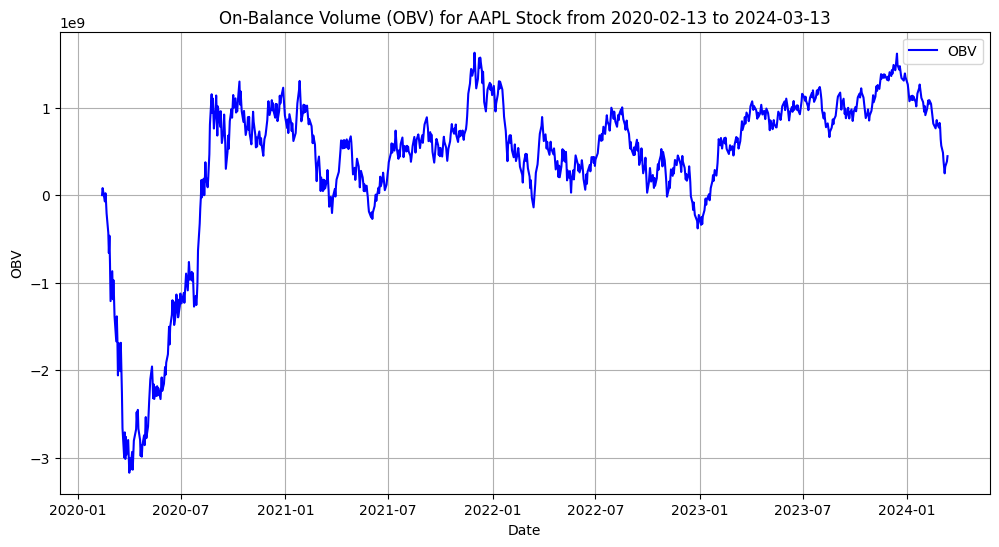

                          Date        OBV
0    2020-02-13 00:00:00+00:00          0
1    2020-02-14 00:00:00+00:00   80113600
2    2020-02-18 00:00:00+00:00  -72417600
3    2020-02-19 00:00:00+00:00   21566400
4    2020-02-20 00:00:00+00:00  -78999600
...                        ...        ...
1021 2024-03-06 00:00:00+00:00  320582100
1022 2024-03-07 00:00:00+00:00  248817000
1023 2024-03-08 00:00:00+00:00  324931600
1024 2024-03-11 00:00:00+00:00  385071100
1025 2024-03-12 00:00:00+00:00  444896500

[1026 rows x 2 columns]


In [36]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

class StockOBV:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None

    def download_data(self):
        """Download historical stock data."""
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)

    def calculate_obv(self):
        """Calculate On-Balance Volume (OBV)."""
        if self.data is not None:
            # Calculate daily price change
            price_change = self.data['Close'].diff()

            # Calculate OBV
            self.data['OBV'] = (price_change > 0).astype(int) * self.data['Volume'] - (price_change < 0).astype(int) * self.data['Volume']
            self.data['OBV'] = self.data['OBV'].cumsum()  # Cumulative sum to get OBV
        else:
            raise ValueError("Data not downloaded. Please call download_data() first.")

    def get_obv_data(self):
        """Return a DataFrame of dates and their corresponding OBV values."""
        if 'OBV' not in self.data.columns:
            raise ValueError("OBV not calculated. Please call calculate_obv() first.")

        # Create a DataFrame with the date and OBV values
        obv_data = self.data[['OBV']].dropna().reset_index()
        obv_data.columns = ['Date', 'OBV']  # Rename columns for clarity

        return obv_data

    def plot_obv(self):
        """Plot the OBV along with the closing price."""
        if 'OBV' not in self.data.columns:
            raise ValueError("OBV not calculated. Please call calculate_obv() first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.data.index, self.data['OBV'], label='OBV', color='blue')
        plt.title(f"On-Balance Volume (OBV) for {self.ticker} Stock from {self.start_date} to {self.end_date}")
        plt.xlabel("Date")
        plt.ylabel("OBV")
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()



In [ ]:
# Example usage
if __name__ == "__main__":
    # Initialize the StockOBV class
    stock_obv = StockOBV(ticker="AAPL", start_date="2020-02-13", end_date="2024-03-13")

    # Download data, calculate OBV, and plot
    stock_obv.download_data()
    stock_obv.calculate_obv()
    stock_obv.plot_obv()

    # Get OBV data for further analysis
    obv_data = stock_obv.get_obv_data()
    print(obv_data)  # Print or save the OBV data as needed

In [37]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

class StockPlotter:
    def __init__(self, ticker, start_date, end_date, data):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = data

    def plot_rsi(self):
        """Plot the RSI along with overbought and oversold lines and stock price overlay."""
        if 'RSI' not in self.data.columns:
            raise ValueError("RSI not calculated. Please calculate RSI before plotting.")

        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plotting RSI
        ax1.plot(self.data.index, self.data['RSI'], label='RSI', color='blue')
        ax1.axhline(30, color='red', linestyle='dotted', linewidth=1, label='Oversold (30)')
        ax1.axhline(70, color='green', linestyle='dotted', linewidth=1, label='Overbought (70)')
        ax1.set_ylim(0, 100)
        ax1.set_ylabel("RSI")
        ax1.set_title(f"RSI and Stock Price for {self.ticker} from {self.start_date} to {self.end_date}")
        ax1.legend(loc="upper left")
        ax1.grid()

        # Overlaying stock price
        ax2 = ax1.twinx()  # Secondary y-axis for stock price
        ax2.plot(self.data.index, self.data['Close'], label='Stock Price', color='black', alpha=0.5)
        ax2.set_ylabel("Stock Price")
        ax2.legend(loc="upper right")

        plt.show()

    def plot_macd(self):
        """Plot the MACD and signal line with stock price overlay using a secondary y-axis."""
        if 'MACD' not in self.data.columns or 'Signal_Line' not in self.data.columns:
            raise ValueError("MACD not calculated. Please calculate MACD before plotting.")

        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Add MACD line (on primary y-axis)
        ax1.plot(self.data.index, self.data['MACD'], label='MACD', color='blue')

        # Add Signal Line (on primary y-axis)
        ax1.plot(self.data.index, self.data['Signal_Line'], label='Signal Line', color='orange')

        # Add horizontal line at zero (on primary y-axis)
        ax1.axhline(0, color='black', linestyle='dashed', linewidth=1)  # Zero line

        # Configure primary y-axis
        ax1.set_title(f"MACD and Stock Price for {self.ticker} from {self.start_date} to {self.end_date}")
        ax1.set_ylabel("MACD")
        ax1.legend(loc="upper left")
        ax1.grid()

        # Overlaying stock price on secondary y-axis
        ax2 = ax1.twinx()  # Secondary y-axis for stock price
        ax2.plot(self.data.index, self.data['Close'], label='Stock Price', color='black', alpha=0.5)
        ax2.set_ylabel("Stock Price")
        ax2.legend(loc="upper right")

        plt.show()

In [38]:
#2/ : import yfinance as yf
import pandas as pd
#from stock_plotter import StockPlotter  # Import the StockPlotter class

class StockAnalysis:
    def __init__(self, ticker: str, start_date: str, end_date: str):
        """
        Initialize StockAnalysis with a ticker symbol, start date, and end date.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.plotter = StockPlotter(ticker, start_date, end_date, self.data)  # Initialize the plotter

    def download_data(self) -> None:
        """
        Download historical stock data with a buffer for indicators.
        """
        # 26 days buffer to ensure initial values stabilize, especially for MACD
        buffer_days = 26
        start_with_buffer = pd.to_datetime(self.start_date) - pd.Timedelta(days=buffer_days)
        self.data = yf.download(self.ticker, start=start_with_buffer.strftime('%Y-%m-%d'), end=self.end_date)

        # Update plotter data
        self.plotter.data = self.data  

    def calculate_rsi(self, period: int = 14) -> None:
        """
        Calculate the Relative Strength Index (RSI) for the stock data.
        """
        if self.data is None:
            raise ValueError("Data not downloaded. Please call download_data() first.")

        delta = self.data['Close'].diff()
        gains = delta.where(delta > 0, 0)
        losses = -delta.where(delta < 0, 0)

        avg_gain = gains.ewm(span=period, min_periods=period).mean()
        avg_loss = losses.ewm(span=period, min_periods=period).mean()

        rs = avg_gain / avg_loss
        self.data['RSI'] = 100 - (100 / (1 + rs))

    def calculate_macd(self, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> None:
        """
        Calculate the Moving Average Convergence Divergence (MACD) and the Signal Line.
        """
        if self.data is None:
            raise ValueError("Data not downloaded. Please call download_data() first.")

        # Calculating the short and long Exponential Moving Averages (EMAs)
        self.data['Short_EMA'] = self.data['Close'].ewm(span=short_window, adjust=False).mean()
        self.data['Long_EMA'] = self.data['Close'].ewm(span=long_window, adjust=False).mean()

        # Calculate MACD and Signal Line
        self.data['MACD'] = self.data['Short_EMA'] - self.data['Long_EMA']
        self.data['Signal_Line'] = self.data['MACD'].ewm(span=signal_window, adjust=False).mean()

        # Remove the buffer rows to avoid misleading initial values
        self.data = self.data.loc[self.start_date:]

    def get_rsi_data(self) -> pd.DataFrame:
        """
        Return a DataFrame of dates and their corresponding RSI values.
        """
        if 'RSI' not in self.data.columns:
            raise ValueError("RSI not calculated. Please call calculate_rsi() first.")

        rsi_data = self.data[['RSI']].dropna().reset_index()
        rsi_data.columns = ['Date', 'RSI']
        return rsi_data

    def get_macd_data(self) -> pd.DataFrame:
        """
        Return a DataFrame of dates and their corresponding MACD and Signal Line values.
        """
        if 'MACD' not in self.data.columns or 'Signal_Line' not in self.data.columns:
            raise ValueError("MACD not calculated. Please call calculate_macd() first.")

        macd_data = self.data[['MACD', 'Signal_Line']].dropna().reset_index()
        macd_data.columns = ['Date', 'MACD', 'Signal Line']
        return macd_data

In [ ]:
# Example usage
if __name__ == "__main__":
    # Initialize the StockOBV class
    stock_obv = StockOBV(ticker="AAPL", start_date="2020-02-13", end_date="2024-03-13")

    # Download data, calculate OBV, and plot
    stock_obv.download_data()
    stock_obv.calculate_obv()
    stock_obv.plot_obv()

    # Get OBV data for further analysis
    obv_data = stock_obv.get_obv_data()
    print(obv_data)  # Print or save the OBV data as needed

In [39]:

# Example usage
if __name__ == "__main__":
    stock_analysis = StockAnalysis(ticker="RBLX", start_date="2023-02-13", end_date="2025-11-02")
    stock_analysis.download_data()

    # Calculate indicators
    stock_analysis.calculate_rsi(period=14)
    stock_analysis.calculate_macd()
    

    # Plot RSI and MACD
    #stock_analysis.plotter.plot_rsi()
    #stock_analysis.plotter.plot_macd()

[*********************100%***********************]  1 of 1 completed


In [40]:
# Get RSI and MACD data for further analysis
rsi_data = stock_analysis.get_rsi_data()
print("RSI Data:\n", rsi_data)

macd_data = stock_analysis.get_macd_data()
print("MACD Data:\n", macd_data)
    
obv_data = stock_obv.get_obv_data()
print(obv_data)  # Print or save the OBV data as needed

RSI Data:
                          Date        RSI
0   2023-02-13 00:00:00+00:00  33.282317
1   2023-02-14 00:00:00+00:00  43.610196
2   2023-02-15 00:00:00+00:00  76.059969
3   2023-02-16 00:00:00+00:00  68.780104
4   2023-02-17 00:00:00+00:00  57.374757
..                        ...        ...
429 2024-10-28 00:00:00+00:00  60.570173
430 2024-10-29 00:00:00+00:00  63.998557
431 2024-10-30 00:00:00+00:00  69.269552
432 2024-10-31 00:00:00+00:00  91.771968
433 2024-11-01 00:00:00+00:00  89.309445

[434 rows x 2 columns]
MACD Data:
                          Date      MACD  Signal Line
0   2023-02-13 00:00:00+00:00  0.104705     0.434950
1   2023-02-14 00:00:00+00:00  0.017087     0.351378
2   2023-02-15 00:00:00+00:00  0.698901     0.420882
3   2023-02-16 00:00:00+00:00  1.105463     0.557799
4   2023-02-17 00:00:00+00:00  1.196012     0.685441
..                        ...       ...          ...
429 2024-10-28 00:00:00+00:00 -0.481599    -0.666048
430 2024-10-29 00:00:00+00:00 -0.3616

In [41]:
data_to_upload = {
    "ticker": str(stock_analysis.ticker),
    "date_range": {
        "start": str(stock_analysis.start_date),
        "end": str(stock_analysis.end_date)
    },
    "indicators": {
        "RSI": str(rsi_data.to_dict(orient='records')),
        "MACD":str( macd_data.to_dict(orient='records')),
        "OBV": str(obv_data.to_dict(orient='records'))
    }
}



In [42]:
# Convertir en JSON
json_data = json.dumps(data_to_upload)

In [43]:

# Nom de votre bucket S3
bucket_name = bucket_name

file_name = 'json_data.json'  # ou un autre nom pour éviter l'écrasement


In [45]:
# Define the S3 configuration for your data source
s3_configuration = {
    'bucketArn': bucket_arn,
    'inclusionPrefixes': [kb_key]  
}

# Define the data source configuration
data_source_configuration = {
    's3Configuration': s3_configuration,
    'type': 'S3'
}

knowledge_base_id = kb_obj["knowledgeBase"]["knowledgeBaseId"]
knowledge_base_arn = kb_obj["knowledgeBase"]["knowledgeBaseArn"]

chunking_strategy_configuration = {
    "chunkingStrategy": "FIXED_SIZE",
    "fixedSizeChunkingConfiguration": {
        "maxTokens": 512,
        "overlapPercentage": 20
    }
}

# Create the data source
try:
    # ensure that the KB is created and available
    time.sleep(45)
    data_source_response = bedrock_agent_client.create_data_source(
        knowledgeBaseId=knowledge_base_id,
        name=data_source_name,
        description='DataSource for the bedrock documentation',
        dataSourceConfiguration=data_source_configuration,
        vectorIngestionConfiguration = {
            "chunkingConfiguration": chunking_strategy_configuration
        }
    )

    # Pretty print the response
    pprint.pprint(data_source_response)

except Exception as e:
    print(f"Error occurred: {e}")

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '623',
                                      'content-type': 'application/json',
                                      'date': 'Sun, 03 Nov 2024 21:56:09 GMT',
                                      'x-amz-apigw-id': 'AsKq9HMMvHcED2Q=',
                                      'x-amzn-requestid': 'a6eb0d6b-ac2c-43dc-91e5-d1405d2ad567',
                                      'x-amzn-trace-id': 'Root=1-6727f178-4926adac142a0d4555ce289f'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'a6eb0d6b-ac2c-43dc-91e5-d1405d2ad567',
                      'RetryAttempts': 0},
 'dataSource': {'createdAt': datetime.datetime(2024, 11, 3, 21, 56, 9, 18719, tzinfo=tzutc()),
                'dataDeletionPolicy': 'DELETE',
                'dataSourceConfiguration': {'s3Configuration': {'bucketArn': 'arn:aws:s3:::my-data-bucket-2024',
                       

In [ ]:
# Télécharger le fichier JSON dans S3
#s3_configuration.put_object(Bucket=bucket_name, Key=file_name, Body=json_data)

#s3_configuration.upload_file('/tmp/hello.txt', Bucket=bucket_name, Body=json_data)
#print(f"Les données ont été ajoutées dans le bucket {bucket_name} sous le nom de fichier {file_name}.")

In [46]:


def lambda_handler(event, context):

    bucket = 'mybucket'
    key = 'id.txt'
    id = None

    # Write id to S3
    s3_configuration.put_object(Body=json_data, Bucket=bucket_name,Key=file_name)


In [47]:
# Start an ingestion job
data_source_id = data_source_response["dataSource"]["dataSourceId"]
start_job_response = bedrock_agent_client.start_ingestion_job(
    knowledgeBaseId=knowledge_base_id, 
    dataSourceId=data_source_id
)

In [48]:
# Create IAM policies for agent
bedrock_agent_bedrock_allow_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "AmazonBedrockAgentBedrockFoundationModelPolicy",
            "Effect": "Allow",
            "Action": "bedrock:InvokeModel",
            "Resource": [
                f"arn:aws:bedrock:{region}::foundation-model/{model_id}"
            ]
        }
    ]
}

bedrock_policy_json = json.dumps(bedrock_agent_bedrock_allow_policy_statement)

agent_bedrock_policy = iam_client.create_policy(
    PolicyName=bedrock_agent_bedrock_allow_policy_name,
    PolicyDocument=bedrock_policy_json
)

In [49]:
bedrock_agent_kb_retrival_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "bedrock:Retrieve"
            ],
            "Resource": [
                knowledge_base_arn
            ]
        }
    ]
}
bedrock_agent_kb_json = json.dumps(bedrock_agent_kb_retrival_policy_statement)
agent_kb_schema_policy = iam_client.create_policy(
    PolicyName=bedrock_agent_kb_allow_policy_name,
    Description=f"Policy to allow agent to retrieve documents from knowledge base.",
    PolicyDocument=bedrock_agent_kb_json
)

In [50]:
# Create IAM Role for the agent and attach IAM policies
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [{
          "Effect": "Allow",
          "Principal": {
            "Service": "bedrock.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
    }]
}

assume_role_policy_document_json = json.dumps(assume_role_policy_document)
agent_role = iam_client.create_role(
    RoleName=agent_role_name,
    AssumeRolePolicyDocument=assume_role_policy_document_json
)

# Pause to make sure role is created
time.sleep(10)
    
iam_client.attach_role_policy(
    RoleName=agent_role_name,
    PolicyArn=agent_bedrock_policy['Policy']['Arn']
)


iam_client.attach_role_policy(
    RoleName=agent_role_name,
    PolicyArn=agent_kb_schema_policy['Policy']['Arn']
)

{'ResponseMetadata': {'RequestId': '57942073-1257-4a71-ba3f-10fa76751113',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sun, 03 Nov 2024 21:56:49 GMT',
   'x-amzn-requestid': '57942073-1257-4a71-ba3f-10fa76751113',
   'content-type': 'text/xml',
   'content-length': '212'},
  'RetryAttempts': 0}}

In [51]:
# Create Agent
response = bedrock_agent_client.create_agent(
    agentName=agent_name,
    agentResourceRoleArn=agent_role['Role']['Arn'],
    description="Agent supporting Amazon Bedrock Developers.",
    idleSessionTTLInSeconds=1800,
    foundationModel=model_id,
    instruction=agent_instruction,
)

In [52]:
agent_id = response['agent']['agentId']
agent_id

'DWXES5GU9W'

In [53]:
agent_kb_description = bedrock_agent_client.associate_agent_knowledge_base(
    agentId=agent_id,
    agentVersion='DRAFT',
    description=f'Use the information in the {kb_name} knowledge base to provide accurate responses to the questions about Amazon Bedrock.',
    knowledgeBaseId=knowledge_base_id 
)

In [54]:
agent_prepare = bedrock_agent_client.prepare_agent(agentId=agent_id)
agent_prepare

{'ResponseMetadata': {'RequestId': '66b045eb-07bd-4fe8-b9a1-2309de3369f3',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Sun, 03 Nov 2024 21:57:39 GMT',
   'content-type': 'application/json',
   'content-length': '119',
   'connection': 'keep-alive',
   'x-amzn-requestid': '66b045eb-07bd-4fe8-b9a1-2309de3369f3',
   'x-amz-apigw-id': 'AsK5GGq6PHcEkjw=',
   'x-amzn-trace-id': 'Root=1-6727f1d3-59ec7b9d67515ec122dae4d3'},
  'RetryAttempts': 0},
 'agentId': 'DWXES5GU9W',
 'agentStatus': 'PREPARING',
 'agentVersion': 'DRAFT',
 'preparedAt': datetime.datetime(2024, 11, 3, 21, 57, 39, 520056, tzinfo=tzutc())}

In [55]:
# Pause to make sure agent is prepared
time.sleep(30)
agent_alias = bedrock_agent_client.create_agent_alias(
    agentId=agent_id,
    agentAliasName=agent_alias_name
)
# Pause to make sure agent alias is ready
time.sleep(30)

In [56]:
agent_alias


{'ResponseMetadata': {'RequestId': '8cbd7e5c-854e-4513-9a7c-9b79a2091a48',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Sun, 03 Nov 2024 21:58:42 GMT',
   'content-type': 'application/json',
   'content-length': '354',
   'connection': 'keep-alive',
   'x-amzn-requestid': '8cbd7e5c-854e-4513-9a7c-9b79a2091a48',
   'x-amz-apigw-id': 'AsLC_E4tPHcEmsQ=',
   'x-amzn-trace-id': 'Root=1-6727f212-65e9f30f5d74df901d77c177'},
  'RetryAttempts': 0},
 'agentAlias': {'agentAliasArn': 'arn:aws:bedrock:us-west-2:939490215743:agent-alias/DWXES5GU9W/7IGJSYRTQY',
  'agentAliasId': '7IGJSYRTQY',
  'agentAliasName': 'bedrock-docs-alias1730670623',
  'agentAliasStatus': 'CREATING',
  'agentId': 'DWXES5GU9W',
  'createdAt': datetime.datetime(2024, 11, 3, 21, 58, 42, 880714, tzinfo=tzutc()),
  'routingConfiguration': [{}],
  'updatedAt': datetime.datetime(2024, 11, 3, 21, 58, 42, 880714, tzinfo=tzutc())}}

In [57]:
# Extract the agentAliasId from the response
agent_alias_id = agent_alias['agentAlias']['agentAliasId']

## create a random id for session initiator id
session_id:str = str(uuid.uuid1())
enable_trace:bool = True
end_session:bool = False



In [59]:
# invoke the agent API
agentResponse = bedrock_agent_runtime_client.invoke_agent(
    inputText="par defaut ",
    agentId=agent_id,
    agentAliasId=agent_alias_id, 
    sessionId=session_id,
    enableTrace=enable_trace, 
    endSession= end_session
)

logger.info(pprint.pprint(agentResponse))

[2024-11-03 16:59:18,108] p3894 {2262335159.py:11} INFO - None


{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-type': 'application/vnd.amazon.eventstream',
                                      'date': 'Sun, 03 Nov 2024 21:59:18 GMT',
                                      'transfer-encoding': 'chunked',
                                      'x-amz-bedrock-agent-session-id': 'dc7a8dd4-9a2e-11ef-8a2b-ea6da52e500f',
                                      'x-amzn-bedrock-agent-content-type': 'application/json',
                                      'x-amzn-requestid': '7426961e-46f3-479a-a2c4-c61898f124bd'},
                      'HTTPStatusCode': 200,
                      'RequestId': '7426961e-46f3-479a-a2c4-c61898f124bd',
                      'RetryAttempts': 0},
 'completion': <botocore.eventstream.EventStream object at 0x161c65580>,
 'contentType': 'application/json',
 'sessionId': 'dc7a8dd4-9a2e-11ef-8a2b-ea6da52e500f'}


In [69]:
%%time
event_stream = agentResponse['completion']
try:
    for event in event_stream:        
        if 'chunk' in event:
            data = event['chunk']['bytes']
            logger.info(f"Final answer ->\n{data.decode('utf8')}")
            agent_answer = data.decode('utf8')
            end_event_received = True
            # End event indicates that the request finished successfully
        elif 'trace' in event:
            logger.info(json.dumps(event['trace'], indent=2))
        else:
            raise Exception("unexpected event.", event)
except Exception as e:
    raise Exception("unexpected event.", e)

CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 6.91 μs


In [70]:
# And here is the response if you just want to see agent's reply


Sorry, I am unable to assist you with this request.


In [72]:
def simple_agent_invoke(input_text, agent_id, agent_alias_id, session_id=None, enable_trace=False, end_session=False):
    if session_id is None:
        session_id:str = str(uuid.uuid1())

    agentResponse = bedrock_agent_runtime_client.invoke_agent(
        inputText=input_text,
        agentId=agent_id,
        agentAliasId=agent_alias_id, 
        sessionId=session_id,
        enableTrace=enable_trace, 
        endSession= end_session
    )
    logger.info(pprint.pprint(agentResponse))
    
    agent_answer = ''
    event_stream = agentResponse['completion']
    try:
        for event in event_stream:        
            if 'chunk' in event:
                data = event['chunk']['bytes']
                logger.info(f"Final answer ->\n{data.decode('utf8')}")
                agent_answer = data.decode('utf8')
                end_event_received = True
                # End event indicates that the request finished successfully
            elif 'trace' in event:
                logger.info(json.dumps(event['trace'], indent=2))
            else:
                raise Exception("unexpected event.", event)
    except Exception as e:
        raise Exception("unexpected event.", e)
    return agent_answer

In [75]:
reponse = simple_agent_invoke("quel DISENT LES RAPPORT SUR HYDRO ONE ? EN FRANCAIS", agent_id, agent_alias_id, session_id)


[2024-11-03 17:04:12,925] p3894 {321621934.py:13} INFO - None


{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-type': 'application/vnd.amazon.eventstream',
                                      'date': 'Sun, 03 Nov 2024 22:04:12 GMT',
                                      'transfer-encoding': 'chunked',
                                      'x-amz-bedrock-agent-session-id': 'dc7a8dd4-9a2e-11ef-8a2b-ea6da52e500f',
                                      'x-amzn-bedrock-agent-content-type': 'application/json',
                                      'x-amzn-requestid': 'c35c1e99-6587-451a-8292-1f2b1c9f574d'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'c35c1e99-6587-451a-8292-1f2b1c9f574d',
                      'RetryAttempts': 0},
 'completion': <botocore.eventstream.EventStream object at 0x161c9ffe0>,
 'contentType': 'application/json',
 'sessionId': 'dc7a8dd4-9a2e-11ef-8a2b-ea6da52e500f'}


[2024-11-03 17:04:19,745] p3894 {321621934.py:21} INFO - Final answer ->
Selon les rapports, les principaux éléments de la stratégie future d'Hydro One sont :

- Investir dans l'expansion et la modernisation des réseaux de transmission et de distribution pour améliorer la fiabilité et l'efficacité du service (6,5 milliards de dollars d'investissements prévus sur 4 ans)
- Poursuivre la transformation en une entreprise axée sur la performance, la rentabilité et l'orientation client
- Incorporer le développement durable dans tous les aspects des activités
- Investir dans l'innovation pour améliorer la fiabilité du service et la viabilité à long terme de l'entreprise


In [77]:
print(reponse)

Selon les rapports, les principaux éléments de la stratégie future d'Hydro One sont :

- Investir dans l'expansion et la modernisation des réseaux de transmission et de distribution pour améliorer la fiabilité et l'efficacité du service (6,5 milliards de dollars d'investissements prévus sur 4 ans)
- Poursuivre la transformation en une entreprise axée sur la performance, la rentabilité et l'orientation client
- Incorporer le développement durable dans tous les aspects des activités
- Investir dans l'innovation pour améliorer la fiabilité du service et la viabilité à long terme de l'entreprise


In [91]:
modelId = 'anthropic.claude-3-sonnet-20240229-v1:0'

bedrock_client = boto3.client('bedrock-agent-runtime', region_name='us-west-2')


In [92]:
from botocore.exceptions import ClientError


In [100]:

# Import python's built-in regular expression library
import re
import boto3
from botocore.exceptions import ClientError
import json

# Import the hints module from the utils package



bedrock_client = boto3.client(service_name='bedrock-runtime', region_name='us-west-2')

In [ ]:
from utils import hints


In [109]:
def get_completion(prompt, system_prompt=None):
    # Define the inference configuration
    inference_config = {
        "temperature": 0.0,  # Set the temperature for generating diverse responses
        "maxTokens": 200,  # Set the maximum number of tokens to generate
        "topP": 1,  # Set the top_p value for nucleus sampling
    }
    # Create the converse method parameters
    converse_api_params = {
        "modelId": modelId,  # Specify the model ID to use
        "messages": [{"role": "user", "content": [{"text": prompt}]}],  # Provide the user's prompt
        "inferenceConfig": inference_config,  # Pass the inference configuration
    }
    # Check if system_text is provided
    if system_prompt:
        # If system_text is provided, add the system parameter to the converse_params dictionary
        converse_api_params["system"] = [{system_prompt}]
            # Send a request to the Bedrock client to generate a response
    try:
        response = bedrock_client.converse(**converse_api_params)

        # Extract the generated text content from the response
        text_content = response['output']['message']['content'][0]['text']

        # Return the generated text content
        return text_content

    except ClientError as err:
        message = err.response['Error']['Message']
        print(f"A client error occured: {message}")



In [145]:

# System prompt
SYSTEM_PROMPT = "donne le resultat dans 20 phrases , toujours  dans un format json avec une cle : rapport , donne le directement , sans texte avant "
#SYSTEM_PROMPT = "Your answer should always be a series of critical thinking questions that further the conversation (do not provide answers to your questions). Do not actually answer the user question."

# Prompt
PROMPT = reponse

# Print Claude's response


In [146]:
print(get_completion(PROMPT , SYSTEM_PROMPT))

{
"rapport": "1. Bell est l'une des plus grandes entreprises de télécommunications au Canada et son avenir dépendra de sa capacité à s'adapter aux nouvelles technologies et tendances du marché. 2. Le déploiement de la 5G sera un enjeu majeur pour Bell dans les prochaines années, car cette nouvelle norme de réseau mobile promet des vitesses plus rapides et une meilleure connectivité. 3. L'entreprise devra investir massivement dans les infrastructures 5G pour rester compétitive face à ses rivaux. 4. Le cloud computing et les services infonuagiques représentent également un secteur en pleine croissance où Bell cherchera à se positionner davantage. 5. Les services de télévision et de vidéo en ligne continueront d'être importants pour Bell, qui devra proposer des contenus attrayants et une expérience utilisateur de qualité. 6. La cybersécurité deviendra un enjeu crucial à mesure que les menaces informatiques se multiplieront, et Bell devra renforcer ses mesures de protection. 7. L'intellige